# 📊 Store Sales Time Series Forecasting - Data Dictionary

---

## 1️⃣ Train Data (Sales Data)
📌 Contains historical daily sales data for each store and product family.

| Column Name   | Description |
|---------------|-------------|
| `id`          | Unique identifier for each record. |
| `date`        | Date of the sale. |
| `store_nbr`   | Store number where the sale occurred. |
| `family`      | Product family (e.g., beverages, canned foods, etc.). |
| `sales`       | Number of units sold on that day. |
| `onpromotion` | Number of products on promotion that day. |

---

## 2️⃣ Test Data (Future Data)
📌 Same structure as the "Train" data but without sales, as the goal is to predict sales for these records.

| Column Name   | Description |
|---------------|-------------|
| `id`          | Unique identifier for each record. |
| `date`        | The date for which sales prediction is required. |
| `store_nbr`   | Store number. |
| `family`      | Product family. |
| `onpromotion` | Number of products on promotion that day. |

---

## 3️⃣ Stores Data
📌 Metadata about each store, such as location and type.

| Column Name   | Description |
|---------------|-------------|
| `store_nbr`   | Store number (links this dataset with sales data). |
| `city`        | The city where the store is located. |
| `state`       | The state or region of the store. |
| `type`        | Store type (A, B, C, D). |
| `cluster`     | Store's cluster based on customer behavior patterns. |

---

## 4️⃣ Oil Prices Data
📌 Daily oil prices that may impact economic conditions and sales.

| Column Name   | Description |
|---------------|-------------|
| `date`        | Date of oil price record. |
| `dcoilwtico`  | Price of a barrel of crude oil. |

---

## 5️⃣ Holidays & Events Data
📌 Contains information about holidays and special events that may influence sales.

| Column Name   | Description |
|---------------|-------------|
| `date`        | Date of the holiday or event. |
| `type`        | Type of event (e.g., National Holiday, Sporting Event, Religious, etc.). |
| `locale`      | Where the event is celebrated (`National`, `Regional`, `Local`). |
| `locale_name` | Name of the region or city affected by the holiday. |
| `description` | Description of the holiday or event. |
| `transferred` | Whether the event was transferred to another day (`True` or `False`). |

---

## 6️⃣ Transactions Data
📌 Daily transaction counts per store.

| Column Name   | Description |
|---------------|-------------|
| `date`        | Date of the transactions. |
| `store_nbr`   | Store number where transactions occurred. |
| `transactions`| Number of transactions on that day. |

---

🔹 **Now you have a well-organized reference for each column in every dataset, which will help you with analysis and accurate sales forecasting! 🚀**  


_____________________________________________________________________
# **ERD**
This is an Entity-Relationship Diagram (ERD) that illustrates the relationships between the different tables (entities) in the dataset, along with their respective attributes. Each entity represents a data table such as sales, stores, holidays, oil prices, and transactions. The diagram helps visualize how these entities are linked together through keys and shared fields, enabling comprehensive analysis and integration of the data.


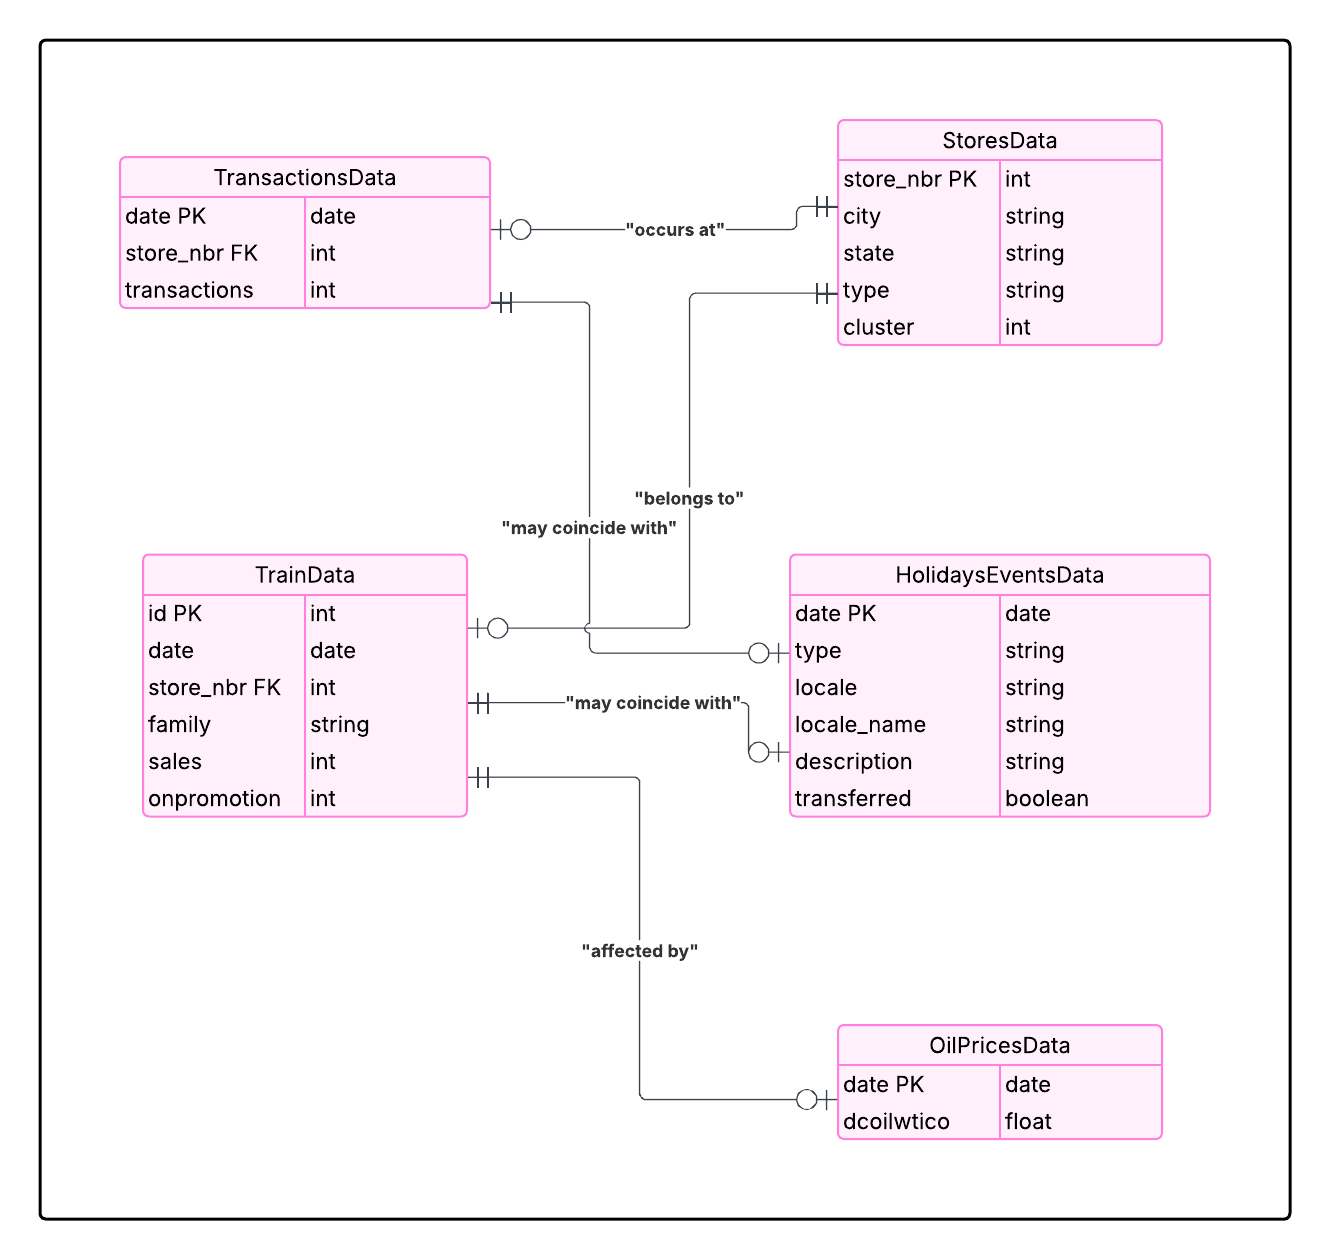

## Importing Libiraries


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")
import mysql.connector

In [4]:
from sklearn.preprocessing import RobustScaler , LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import mlflow

# Data Loading

In [8]:
db_conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = '',
    database = 'Store_Sales_db'
)

cursor = db_conn.cursor(buffered=True)
print('Database connected')

Database connected


In [10]:
# load dataframes
cursor.execute('SELECT * FROM training_5')
train = pd.DataFrame(cursor.fetchall(), 
                   columns=['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


## Data Preparation for modeling

In [123]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [125]:
train.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


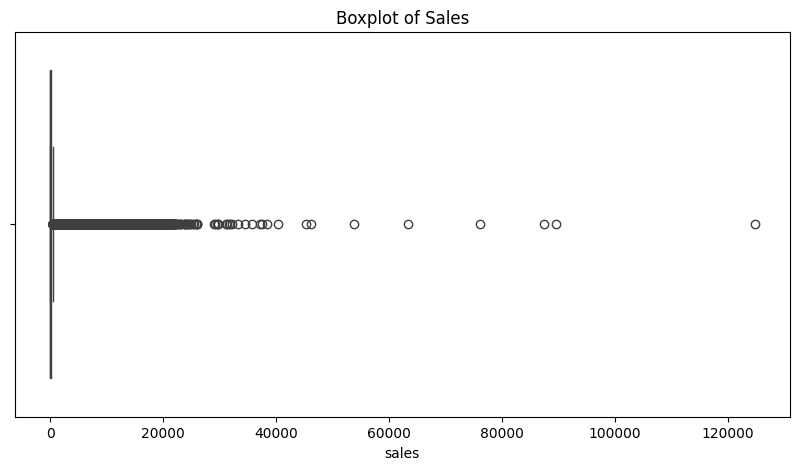

In [126]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=train['sales'])
plt.title('Boxplot of Sales')
plt.show()


In [15]:
X = train.drop(columns=["sales"])
y = train["sales"]

In [17]:
X.head()

,id,date,store_nbr,family,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0
1,1,2013-01-01,1,BABY CARE,0
2,2,2013-01-01,1,BEAUTY,0
3,3,2013-01-01,1,BEVERAGES,0
4,4,2013-01-01,1,BOOKS,0


In [19]:
y

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
3000883     438.133
3000884     154.553
3000885    2419.730
3000886     121.000
3000887      16.000
Name: sales, Length: 3000888, dtype: float64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [23]:
X_train.head()

,id,date,store_nbr,family,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0
1,1,2013-01-01,1,BABY CARE,0
2,2,2013-01-01,1,BEAUTY,0
3,3,2013-01-01,1,BEVERAGES,0
4,4,2013-01-01,1,BOOKS,0


In [25]:
def prepare_datetime_features(df):
    # 🕒 Ensure the date is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # 🧩 Extract time-based features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Friday and Saturday

    # 🔄 Cyclical Encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)


    df.drop(columns=['month', 'day', 'day_of_week',"id"], inplace=True)

    return df.head()


In [27]:
prepare_datetime_features(X_train)
prepare_datetime_features(X_test)
# for visualization
X_test_dates = X_test["date"]

X_train.drop(columns=["date"],axis = 1 , inplace=True)
X_test.drop(columns=["date"],axis = 1,  inplace=True)

In [28]:
# Create and fit the LabelEncoder
family_label_encoder = LabelEncoder()
X_train['family_encoded'] = family_label_encoder.fit_transform(X_train['family'])
X_test['family_encoded'] = family_label_encoder.transform(X_test['family'])

# Drop the original 'family' column
train.drop(columns=['family'], inplace=True)

# Save the encoder for future use
with open("family_label_encoder.pkl", "wb") as f:
    pickle.dump(family_label_encoder, f)

# Preview the result
train.head()


,id,date,store_nbr,sales,onpromotion
0,0,2013-01-01,1,0.0,0
1,1,2013-01-01,1,0.0,0
2,2,2013-01-01,1,0.0,0
3,3,2013-01-01,1,0.0,0
4,4,2013-01-01,1,0.0,0


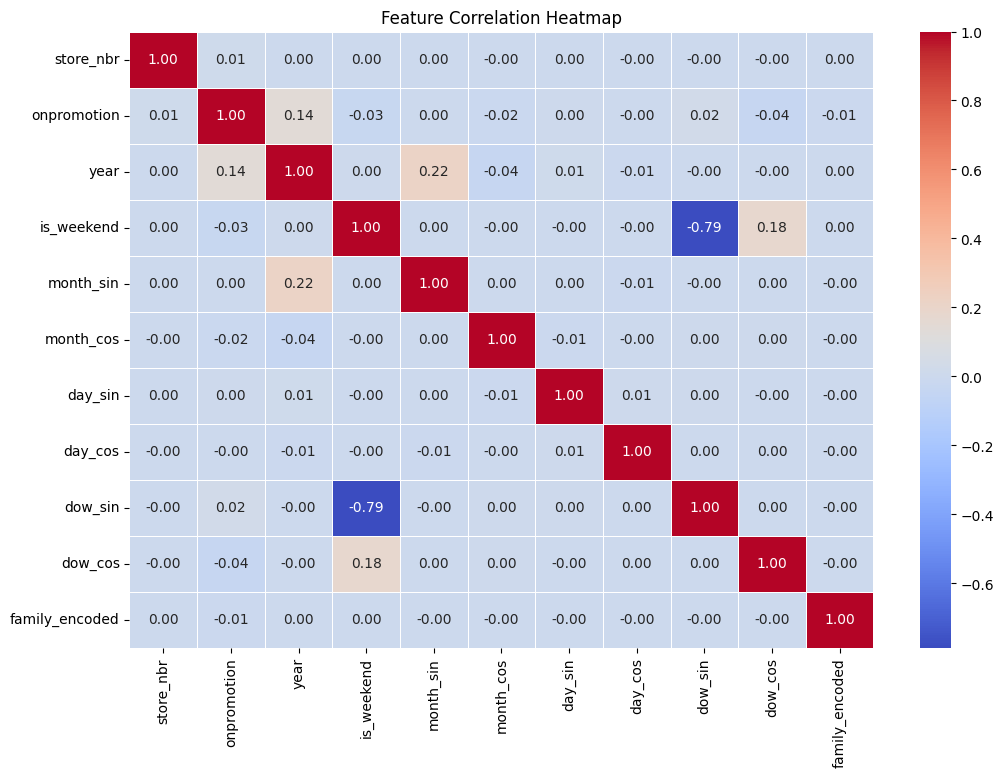

In [30]:
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr(numeric_only=True)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [33]:
numerical_cols = ['onpromotion', 'year', 'is_weekend',
                  'month_sin', 'month_cos', 'day_sin', 'day_cos',
                  'dow_sin', 'dow_cos']

x_scaler = RobustScaler()
X_train = x_scaler.fit_transform(X_train[numerical_cols])
X_test = x_scaler.transform(X_test[numerical_cols])

with open("x_scaler.pkl", "wb") as f:
    pickle.dump(x_scaler, f)

 

In [35]:
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

y_scaler = RobustScaler()
y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

with open("y_scaler.pkl", "wb") as f:
    pickle.dump(y_scaler, f)



In [37]:
y_train

array([[-0.04024347],
       [-0.04024347],
       [-0.04024347],
       ...,
       [10.34613699],
       [-0.02299627],
       [ 0.12158128]])

In [45]:
# ---------------------------
# 1. Define parameter grid
# ---------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# ---------------------------
# 2. Grid Search
# ---------------------------
xgb = XGBRegressor(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# ---------------------------
# 3. Best Model Evaluation
# ---------------------------
best_model = grid_search.best_estimator_

# Train performance
y_train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae  = mean_absolute_error(y_train, y_train_pred)
train_r2   = r2_score(y_train, y_train_pred)

print("\n✅ Train Performance:")
print(f"  - RMSE: {train_rmse:.2f}")
print(f"  - MAE : {train_mae:.2f}")
print(f"  - R²  : {train_r2:.2f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Train Performance:
  - RMSE: 5.12
  - MAE : 2.18
  - R²  : 0.23


In [47]:
# Test performance
y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_r2   = r2_score(y_test, y_test_pred)

print("\n✅ Test Performance:")
print(f"  - RMSE: {test_rmse:.2f}")
print(f"  - MAE : {test_mae:.2f}")
print(f"  - R²  : {test_r2:.2f}")

# Best params
print("\n🔍 Best Hyperparameters:")
print(grid_search.best_params_)


✅ Test Performance:
  - RMSE: 6.59
  - MAE : 3.34
  - R²  : 0.25

🔍 Best Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [97]:
# save experiment
# MLFlow init
mlflow.set_experiment('XGBRegressor')
mlflow.set_tracking_uri('http://127.0.0.1:5000')
best_params = {
    'learning_rate': 0.2,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 42,
    'n_jobs': -1
}
metrics = {
    'RMSE': 5.12,
    'MAE': 3.34,
    'r2' : 0.25
}
with mlflow.start_run(run_name='XGB'):
    mlflow.log_params(best_params)
    mlflow.log_metrics(metrics)
print('model has been registed')

with open("best_model.pkl","wb") as f:
    pickle.dump(best_model,f)
print('model has been saved')

🏃 View run XGB at: http://127.0.0.1:5000/#/experiments/326368103098080991/runs/f8570755495b4c279daad26b7c5959bb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/326368103098080991
model has been registed
model has been saved
